In [1]:
import torch
import argparse
from torch.nn import CrossEntropyLoss
from torch.optim import SGD

from avalanche.benchmarks.classic import SplitMNIST
from avalanche.models import SimpleMLP
from avalanche.training.plugins.early_stopping import EarlyStoppingPlugin
from avalanche.training.supervised import Naive
from avalanche.evaluation.metrics import (
    forgetting_metrics,
    accuracy_metrics,
    loss_metrics,
    timing_metrics,
    cpu_usage_metrics,
    confusion_matrix_metrics,
    disk_usage_metrics,
    CumulativeAccuracyPluginMetric,
    CumulativeForgettingPluginMetric,
    ExperienceMaxRAM,
    ExperienceMaxGPU
)
from avalanche.logging import InteractiveLogger, TextLogger
from avalanche.training.plugins import EvaluationPlugin, EarlyStoppingPlugin
from avalanche.checkpointing import maybe_load_checkpoint, save_checkpoint
import numpy as np
# import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import mlflow
# Device config
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import mlflow
mlflow.set_tracking_uri("postgresql+psycopg2://user:password@db:5432/mlflow")
mlflow.set_experiment("continual-learning-experiment")

2024/07/09 17:24:26 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2024/07/09 17:24:26 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl PostgresqlImpl.
INFO  [alembic.runtime.migration] Will assume transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade 97727af70f4d -> 3500859a5d39, Add Model Aliases table
INFO  [alembic.runtime.migration] Running upgrade 3500859a5d39 -> 7f2a7d5fae7d, add datasets inputs input_tags tables
INFO  [alembic.runtime.migration] Running upgrade 7f2a7d5fae7d -> 2d6e25af4d3e, increase max param val length from 500 to 8000
INFO  [alembic.runtime.migration] Running upgrade 2d6e25af4d3e -> acf3f17fdcc7, add storage location field to model versions
INFO  [alembic.runtime.migration] Running upgrade acf3f17fdcc7 -> 867495a8f9d4, add trace tables
INFO  [alembic.runtime.migration] Running upgrade 867495a8f9d4 -> 5b0e9adcef9c, add cascade deletion to trace tables foreign keys
INFO  [

<Experiment: artifact_location='/home/jovyan/work/mlruns/1', creation_time=1720545866959, experiment_id='1', last_update_time=1720545866959, lifecycle_stage='active', name='continual-learning-experiment', tags={}>

In [3]:
model = SimpleMLP(num_classes=10)

benchmark = SplitMNIST(n_experiences=5, seed = 1, fixed_class_order=list(range(10)))

# Than we can extract the parallel train and test streams
train_stream = benchmark.train_stream
test_stream = benchmark.test_stream

# Prepare for training & testing
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = CrossEntropyLoss()


# Evaluation metric
interactive_logger = InteractiveLogger()

eval_plugin = EvaluationPlugin(
        accuracy_metrics(minibatch=False, epoch=False, experience=True, stream=True),
        loss_metrics(minibatch=False, epoch=False, experience=True, stream=True),
        timing_metrics(epoch=False, epoch_running=True),
        forgetting_metrics(experience=True, stream=True),
        cpu_usage_metrics(experience=True),
        confusion_matrix_metrics(
            num_classes=10, save_image=True, absolute_class_order= True, stream=True
        ),
        CumulativeAccuracyPluginMetric(),
        CumulativeForgettingPluginMetric(),
        ExperienceMaxGPU(gpu_id=0),
        ExperienceMaxRAM(),
        disk_usage_metrics(minibatch=False, epoch=False, experience=True, stream=True),
        loggers=[TextLogger(open('out.txt', 'w')), interactive_logger]
    )
BATCH_SIZE= 1024

/opt/conda/lib/python3.11/site-packages/avalanche/evaluation/metrics/gpu_usage.py:56: UserWarning: Your system has no GPU!
  warnings.warn("Your system has no GPU!")


In [4]:
def reset_parameters(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

In [5]:
for id, experience in enumerate(train_stream):
  print(f"Task {experience.task_label}")
  print(f"Classes in this experience {experience.classes_in_this_experience}")
  dataset = experience.dataset
  print(f"Train data contains {len(dataset)} patterns. With benchmark {train_stream.benchmark}")
  # for x, y, t in dataset:
  #   pass

  test_experience = test_stream[id]
  cumulative_test = test_stream[:id+1]
  print(f"Test data contains {len(test_experience.dataset)}")

Task 0
Classes in this experience [0, 1]
Train data contains 12665 patterns. With benchmark <avalanche.benchmarks.scenarios.deprecated.new_classes.nc_scenario.NCScenario object at 0x7dc8d3f8e610>
Test data contains 2115
Task 0
Classes in this experience [2, 3]
Train data contains 12089 patterns. With benchmark <avalanche.benchmarks.scenarios.deprecated.new_classes.nc_scenario.NCScenario object at 0x7dc8d3f8e610>
Test data contains 2042
Task 0
Classes in this experience [4, 5]
Train data contains 11263 patterns. With benchmark <avalanche.benchmarks.scenarios.deprecated.new_classes.nc_scenario.NCScenario object at 0x7dc8d3f8e610>
Test data contains 1874
Task 0
Classes in this experience [6, 7]
Train data contains 12183 patterns. With benchmark <avalanche.benchmarks.scenarios.deprecated.new_classes.nc_scenario.NCScenario object at 0x7dc8d3f8e610>
Test data contains 1986
Task 0
Classes in this experience [8, 9]
Train data contains 11800 patterns. With benchmark <avalanche.benchmarks.scenar

## Naive model

In [6]:
# cl_strategy = Naive(
#     model,
#     optimizer,
#     criterion,
#     train_mb_size=BATCH_SIZE,
#     train_epochs=100,
#     eval_mb_size=BATCH_SIZE,
#     device=device,
#     eval_every=1,
#     evaluator = eval_plugin,
#     plugins=[EarlyStoppingPlugin(5, "test_stream")],
# )

# # train and test loop
# naive_results = []
# for train_task, test_task in zip(train_stream, test_stream):
#   print()
#   print()
#   print("Current Classes: ", train_task.classes_in_this_experience)
#   cl_strategy.train(train_task, eval_streams=[test_task])
#   naive_results.append(cl_strategy.eval(test_stream))

## GDUMB 

In [6]:
from avalanche.training.plugins import GDumbPlugin

# Prepare for training & testing
reset_parameters(model)

optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = CrossEntropyLoss()


# Continual learning strategy with default logger
cl_strategy = Naive(
    model,
    optimizer,
    criterion,
    train_mb_size=BATCH_SIZE,
    train_epochs=100,
    eval_mb_size=BATCH_SIZE,
    device=device,
    eval_every=1,
    evaluator = eval_plugin,
    plugins=[EarlyStoppingPlugin(5, "test_stream"), GDumbPlugin(mem_size=500)],
)

# train and test loop
gdumb_results = []
# for train_task, test_task in zip(train_stream, test_stream):
#   print()
#   print()
#   print("Current Classes: ", train_task.classes_in_this_experience)
#   cl_strategy.train(train_task, eval_streams=[test_task])
#   gdumb_results.append(cl_strategy.eval(test_stream))

/opt/conda/lib/python3.11/site-packages/avalanche/training/templates/base.py:468: PositionalArgumentsDeprecatedWarning: Avalanche is transitioning to strategy constructors that accept named (keyword) arguments only. This is done to ensure that there is no confusion regarding the meaning of each argument (strategies can have many arguments). Your are passing 3 positional arguments to the Naive.__init__ method. Consider passing them as names arguments. The ability to pass positional arguments will be removed in the future.
  warnings.warn(error_str, category=PositionalArgumentsDeprecatedWarning)


In [7]:
metric_map = {'Top1_Acc_Exp': 'Top1_Acc_Exp',
 'Loss_Exp': 'Loss_Exp',
 'CPUUsage_Exp': 'CPU_Usage',
 'MaxGPU0Usage_Experience': 'Max_GPU_Usage',
 'MaxRAMUsage_Experience': 'Max_RAM_Usage',
 'DiskUsage_Exp': 'Disk_Usage',
 'Top1_Acc_Stream': 'Top1_Acc_Stream',
 'Loss_Stream': 'Loss_Stream',
 'StreamForgetting': 'Stream_Forgetting',
 'DiskUsage_Stream': 'Disk_Usage_Stream',
 'RunningTime_Epoch': 'Running_Time',
 'CumulativeAccuracy': 'Cumulative_Accuracy',
 'CumulativeForgetting': 'Cumulative_Forgetting'}

2024/07/09 17:24:34 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



-- >> Start of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 3/3 [00:00<00:00, 12.04it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	CPUUsage_Exp/eval_phase/test_stream/Task000/Exp000 = 100.4170
	DiskUsage_Exp/eval_phase/test_stream/Task000/Exp000 = 64275.1055
	Loss_Exp/eval_phase/test_stream/Task000/Exp000 = 2.4264
	MaxGPU0Usage_Experience/eval_phase/test_stream/Task000/Exp000 = 0
	MaxRAMUsage_Experience/eval_phase/test_stream/Task000/Exp000 = 0
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.0085


/opt/conda/lib/python3.11/site-packages/avalanche/training/plugins/early_stopping.py:114: UserWarning: Metric Top1_Acc_Stream used by the EarlyStopping plugin is not computed yet. EarlyStopping will not be triggered.
  warnings.warn(


-- >> End of eval phase << --
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x7dc8d2f0c790>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 64275.1055
	Loss_Stream/eval_phase/test_stream/Task000 = 2.4264
	StreamForgetting/eval_phase/test_stream = 0.0000
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.0085
100%|██████████| 1/1 [00:00<00:00, 15.76it/s]
Epoch 0 ended.
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0641
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 3/3 [00:00<00:00,  8.87it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	CPUUsage_Exp/eval_phase/test_stream/Task000/Exp000 = 95.3034
	DiskUsage_Exp/eval_phase/test_stream/Task000/Exp000 = 64275.1055
	Loss_Exp/eval_phase/test_stream/Task000/Exp000 = 2.3856
	MaxGPU0Usage_Experience/eval_phase/test_stream/Task000/Exp000 = 0
	MaxRAMUsage_Experience/eval_phase/test_stream/T

/opt/conda/lib/python3.11/site-packages/avalanche/evaluation/metric_utils.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


-- >> End of eval phase << --
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x7dc8cffe5390>
	CumulativeAccuracy/eval_phase/test_stream/Exp000 = 0.9972
	CumulativeForgetting/eval_phase/test_stream/Exp000 = -0.7002
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 64291.0771
	Loss_Stream/eval_phase/test_stream/Task000 = 0.2438
	StreamForgetting/eval_phase/test_stream = 0.0000
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.9972
100%|██████████| 1/1 [00:00<00:00, 13.30it/s]
Epoch 20 ended.
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0770
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 3/3 [00:00<00:00, 12.39it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	CPUUsage_Exp/eval_phase/test_stream/Task000/Exp000 = 99.6087
	DiskUsage_Exp/eval_phase/test_stream/Task000/Exp000 = 64291.0771
	Loss_Exp/eval_phase/test_stream/Task000/Exp000 = 

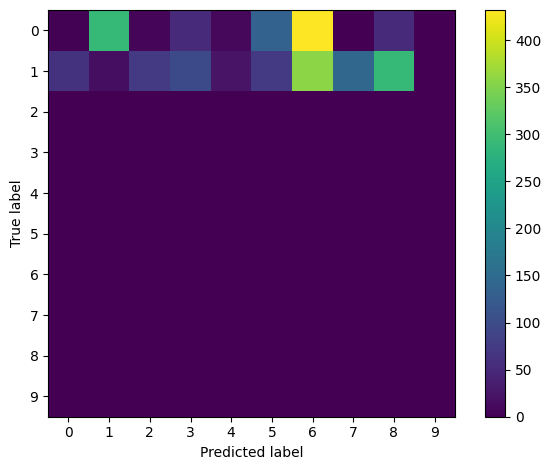

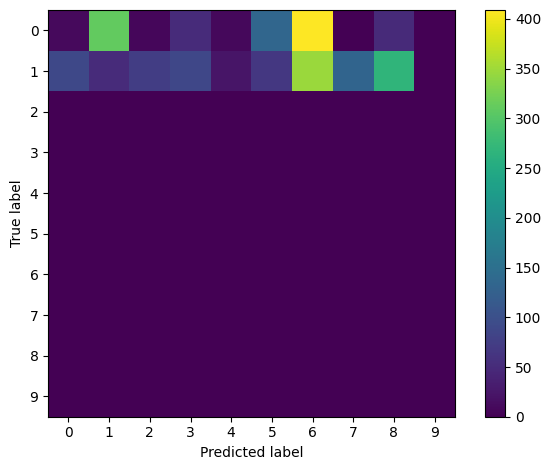

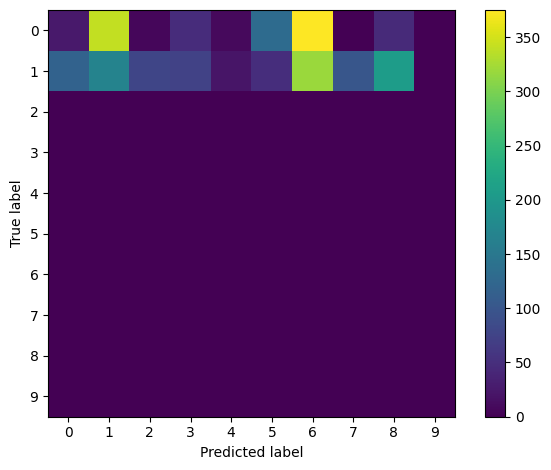

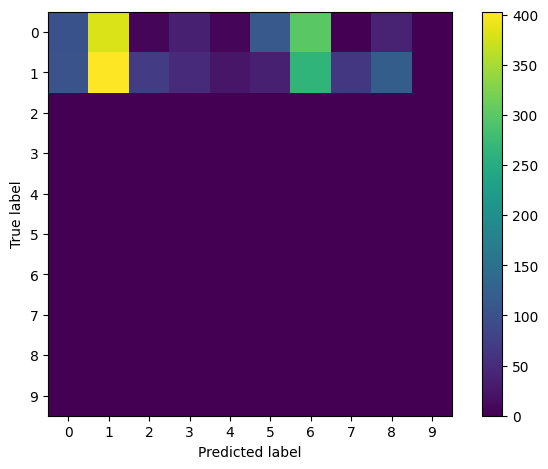

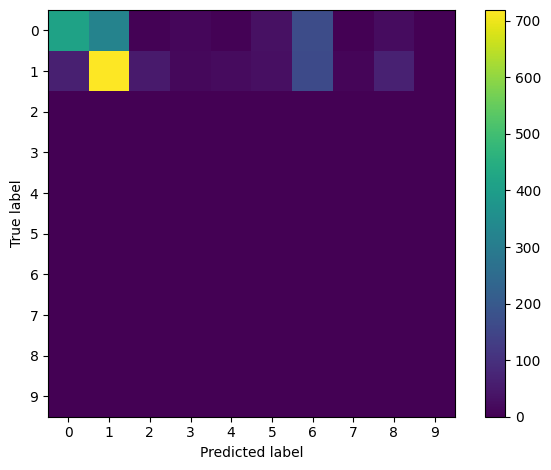

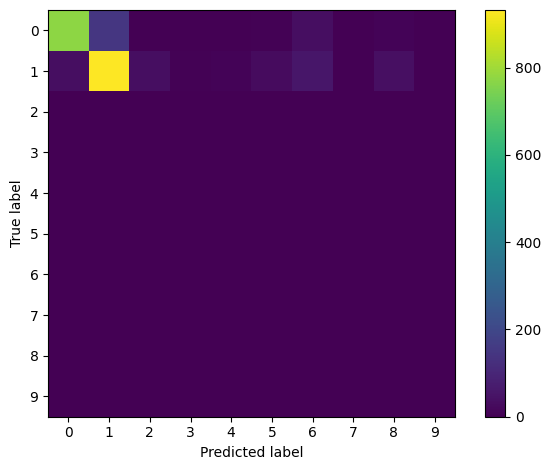

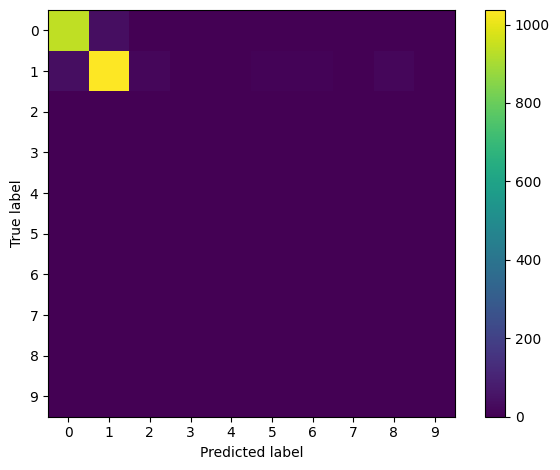

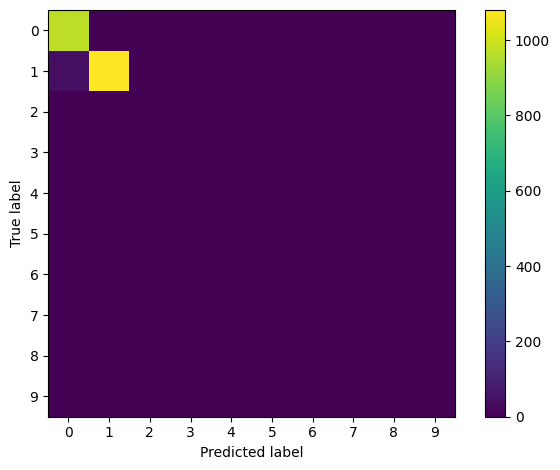

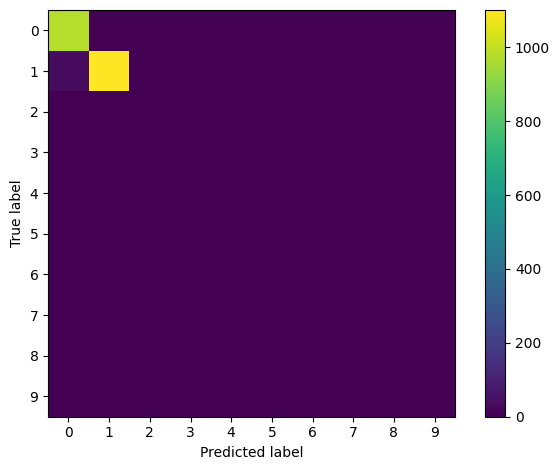

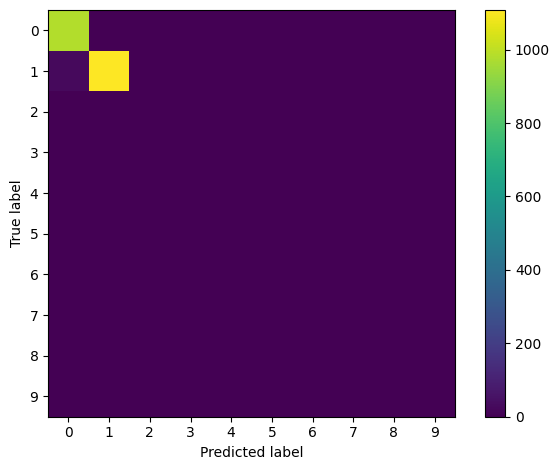

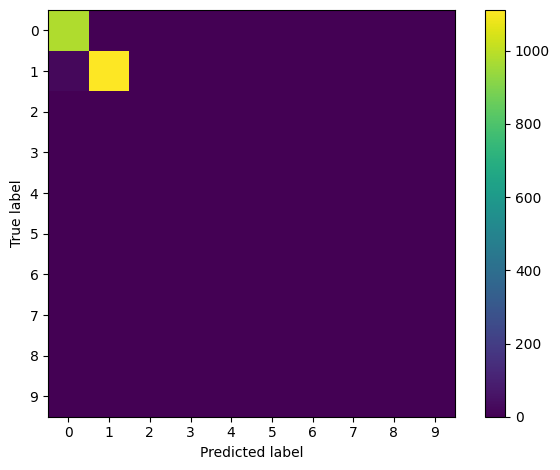

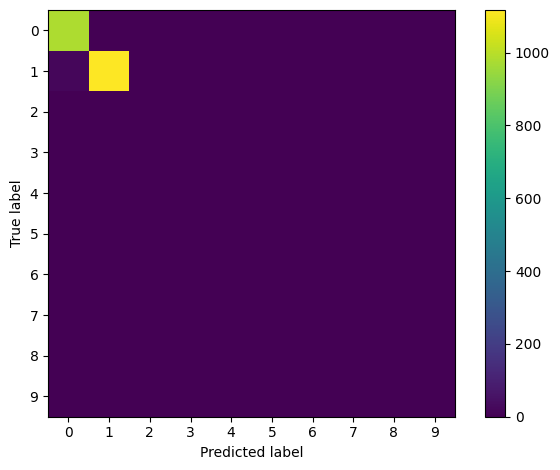

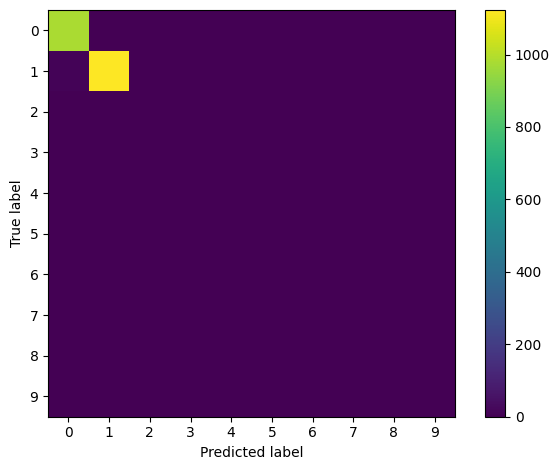

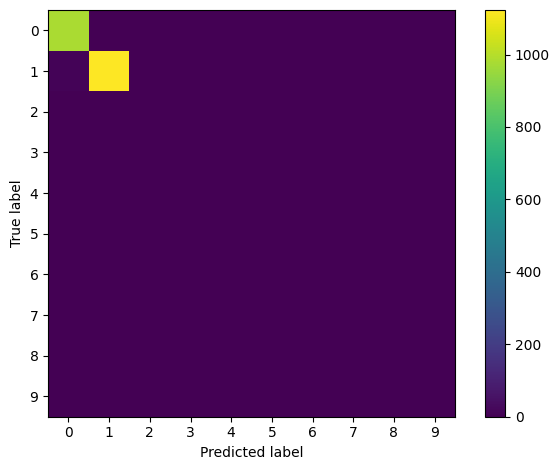

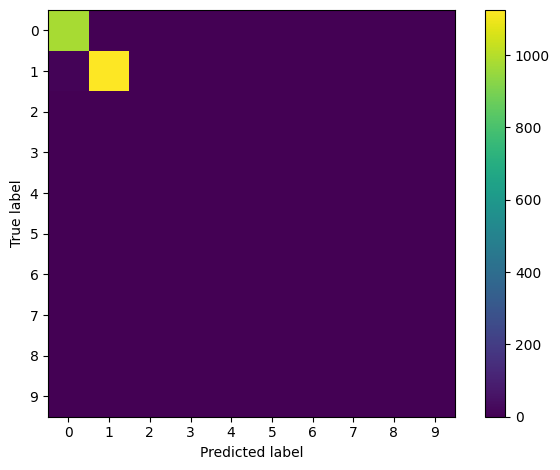

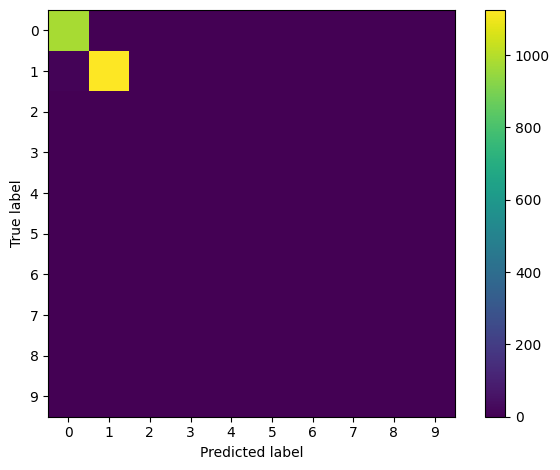

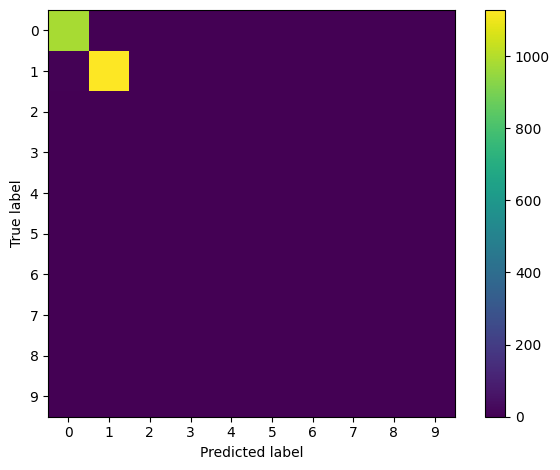

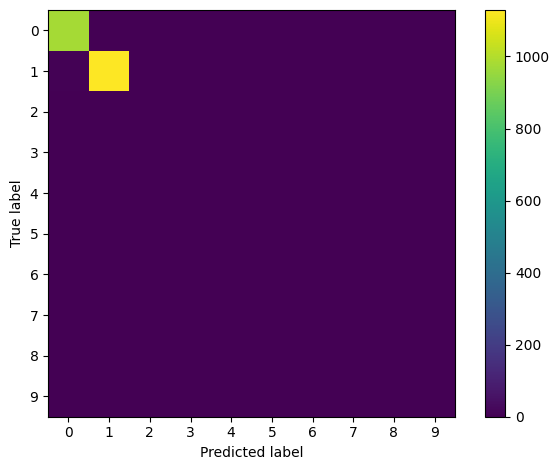

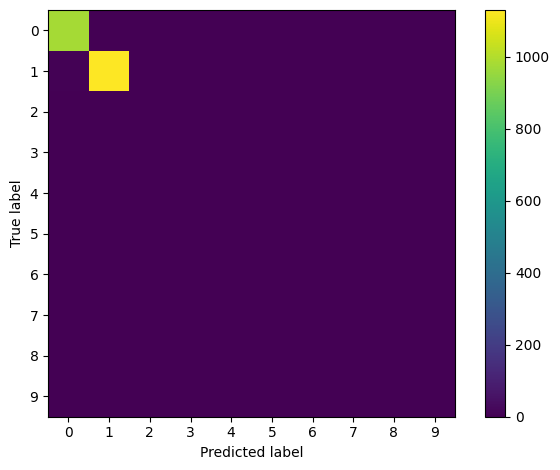

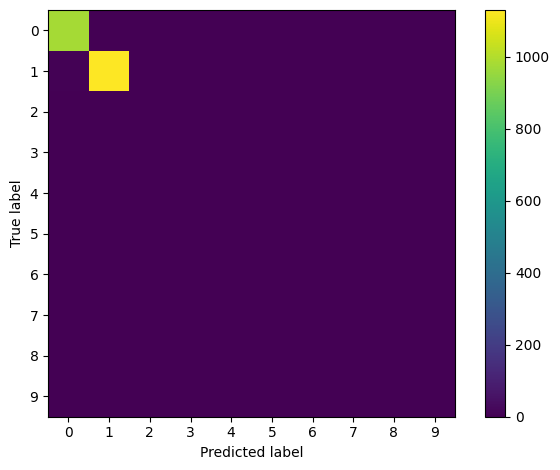

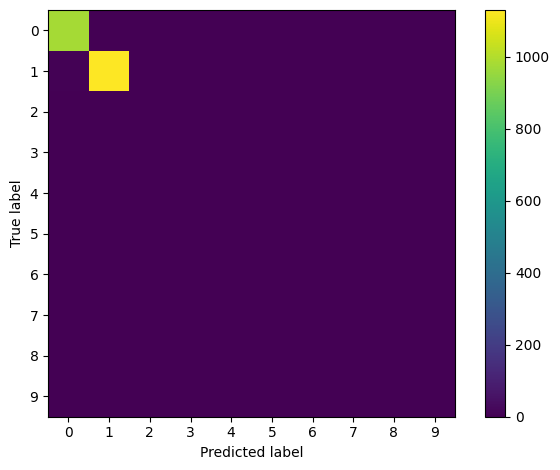

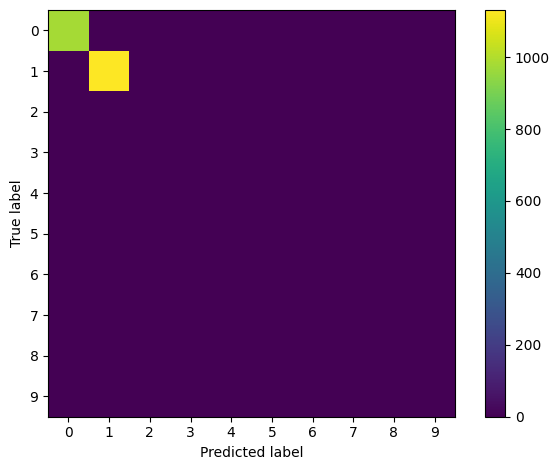

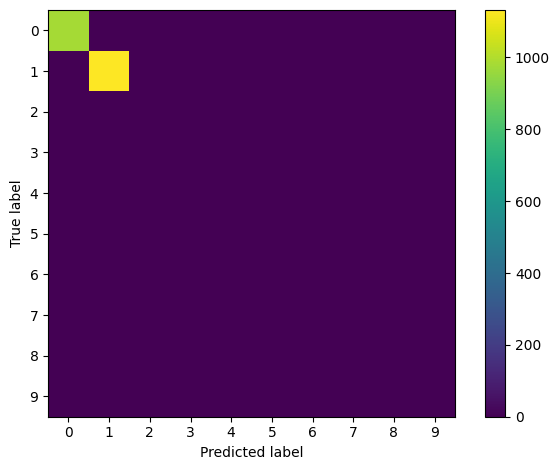

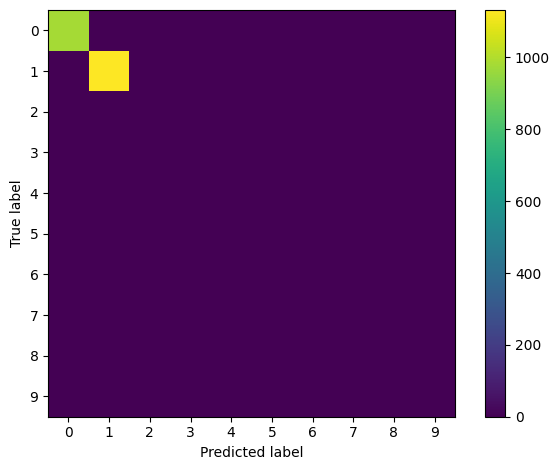

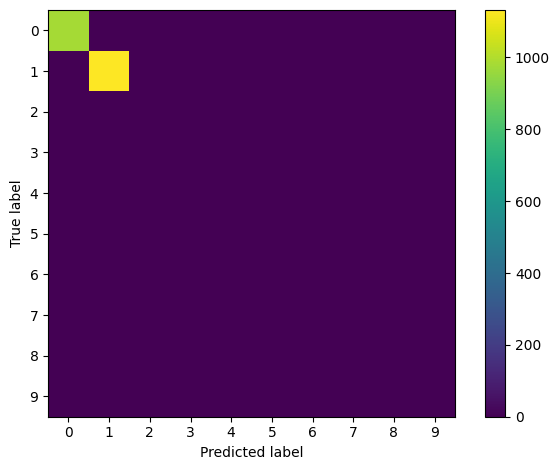

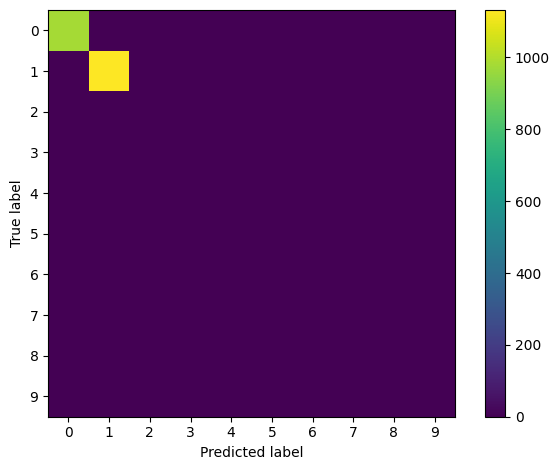

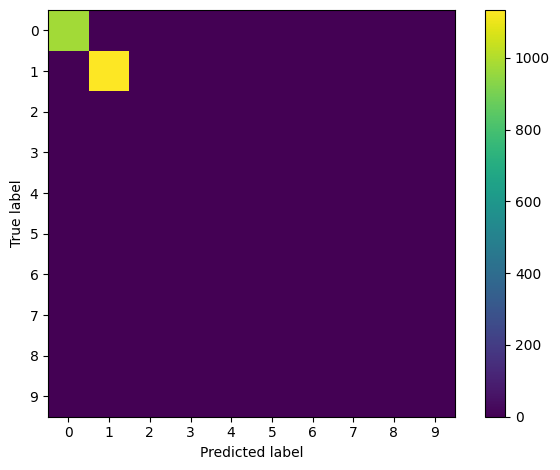

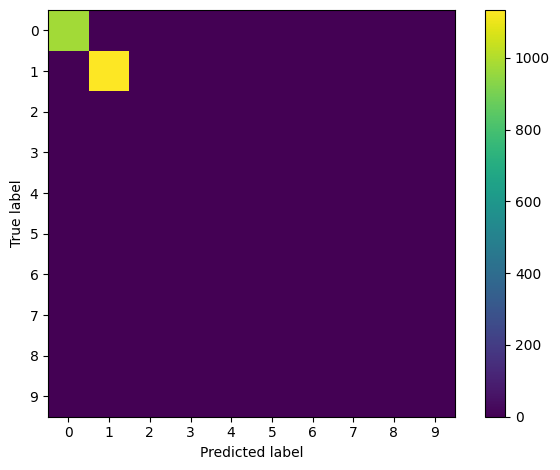

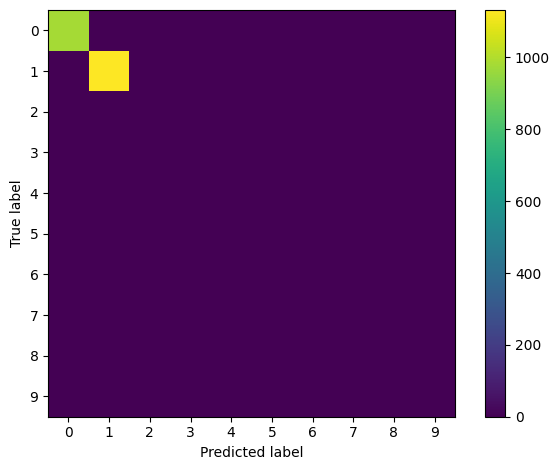

In [8]:
episode = 0
with mlflow.start_run():
    mlflow.log_param("Labels", train_stream[0].classes_in_this_experience)
    hist = cl_strategy.train(train_stream[0], eval_streams=[test_stream[0]])
    eval = cl_strategy.eval(test_stream[0])
    mlflow.log_metrics({"train_"+metric_map.get(key.split('/')[0]):value for key, value in hist.items() if metric_map.get(key.split('/')[0])})
    mlflow.log_metrics({"eval_"+metric_map.get(key.split('/')[0]):value for key, value in eval.items() if metric_map.get(key.split('/')[0])})
    save_checkpoint(cl_strategy, "./gdumb")
    mlflow.log_artifact("./gdumb")

In [9]:
!ls

gdumb  mlruns  out.txt	Untitled.ipynb


In [9]:
mlflow.log_artifact("./gdumb")


In [42]:
strategy, initial_exp = maybe_load_checkpoint(cl_strategy, "./gdumb")

In [43]:
initial_exp

0